In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# File path
file_path = r"C:\Users\Haripriya.R\Desktop\studies\SmartWindDashboard\data\cleaned_weather_data.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Display the first 5 rows
print(df.head())


       STATION        DATE   LATITUDE  LONGITUDE  ELEVATION  \
0  43279099999  2003-01-01  12.994414  80.180517      15.84   
1  43279099999  2003-01-02  12.994414  80.180517      15.84   
2  43279099999  2003-01-03  12.994414  80.180517      15.84   
3  43279099999  2003-01-04  12.994414  80.180517      15.84   
4  43279099999  2003-01-05  12.994414  80.180517      15.84   

                        NAME  TEMP  TEMP_ATTRIBUTES  DEWP  DEWP_ATTRIBUTES  \
0  CHENNAI INTERNATIONAL, IN  78.0               11  68.7               11   
1  CHENNAI INTERNATIONAL, IN  77.8               11  68.7               11   
2  CHENNAI INTERNATIONAL, IN  79.1               11  69.2               11   
3  CHENNAI INTERNATIONAL, IN  78.6                9  67.9                9   
4  CHENNAI INTERNATIONAL, IN  79.0               10  68.4               10   

   ...   MAX  MAX_ATTRIBUTES   MIN  MIN_ATTRIBUTES  PRCP  PRCP_ATTRIBUTES  \
0  ...  88.2                  68.0                   0.0                D  

In [3]:
# Check for NaN values in each column
print("NaN values in columns before cleaning:\n", df.isnull().sum())

# Identify numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Fill NaN for numeric columns with their median
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

print("NaN values after filling median for numeric columns:\n", df.isnull().sum())

# Fill NaN in non-numeric columns with a placeholder
non_numeric_columns = df.select_dtypes(exclude=['float64', 'int64']).columns
df[non_numeric_columns] = df[non_numeric_columns].fillna('Unknown')



print("Final NaN values in the dataset:\n", df.isnull().sum())



NaN values in columns before cleaning:
 STATION                0
DATE                   0
LATITUDE               0
LONGITUDE              0
ELEVATION              0
NAME                   0
TEMP                   0
TEMP_ATTRIBUTES        0
DEWP                   0
DEWP_ATTRIBUTES        0
SLP                 7281
SLP_ATTRIBUTES         0
STP                 7279
STP_ATTRIBUTES         0
VISIB                  1
VISIB_ATTRIBUTES       0
WDSP                   0
WDSP_ATTRIBUTES        0
MXSPD                  5
GUST                6194
MAX                    0
MAX_ATTRIBUTES         0
MIN                    0
MIN_ATTRIBUTES         0
PRCP                   0
PRCP_ATTRIBUTES        0
FRSHTT                 0
Month                  0
Day                    0
Humidity               0
dtype: int64
NaN values after filling median for numeric columns:
 STATION             0
DATE                0
LATITUDE            0
LONGITUDE           0
ELEVATION           0
NAME                0
TEMP       

In [4]:
# Convert 'DATE' to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Extract date features
df['Year'] = df['DATE'].dt.year
df['Month'] = df['DATE'].dt.month
df['Day'] = df['DATE'].dt.day

# Add custom features
df['Temp_Range'] = df['MAX'] - df['MIN']  # Temperature range
df['Wind_Range'] = df['MXSPD'] - df['WDSP']  # Wind speed variation
df['Humidity_Index'] = df['TEMP'] / df['Humidity']  # Custom feature

# Drop 'DATE' column after feature extraction
df = df.drop(columns=['DATE'], axis=1)

# Display updated DataFrame
print(df.head())


       STATION   LATITUDE  LONGITUDE  ELEVATION                       NAME  \
0  43279099999  12.994414  80.180517      15.84  CHENNAI INTERNATIONAL, IN   
1  43279099999  12.994414  80.180517      15.84  CHENNAI INTERNATIONAL, IN   
2  43279099999  12.994414  80.180517      15.84  CHENNAI INTERNATIONAL, IN   
3  43279099999  12.994414  80.180517      15.84  CHENNAI INTERNATIONAL, IN   
4  43279099999  12.994414  80.180517      15.84  CHENNAI INTERNATIONAL, IN   

   TEMP  TEMP_ATTRIBUTES  DEWP  DEWP_ATTRIBUTES     SLP  ...  PRCP  \
0  78.0               11  68.7               11  1013.1  ...   0.0   
1  77.8               11  68.7               11  1015.1  ...   0.0   
2  79.1               11  69.2               11  1015.0  ...   0.0   
3  78.6                9  67.9                9  1014.9  ...   0.0   
4  79.0               10  68.4               10  1015.6  ...   0.0   

   PRCP_ATTRIBUTES  FRSHTT  Month  Day   Humidity  Year  Temp_Range  \
0                D       0      1    1 

In [26]:
# Define the target column
target = 'WDSP'  # Wind speed prediction

# Identify numeric columns only
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Define features (X) and target (y)
X = df[numeric_columns].drop(columns=[target], errors='ignore')  # Replace 'target_column_name' with your target column
y = df[target]  # Replace 'target_column_name' with the actual column name
from sklearn.preprocessing import StandardScaler

# Standardize features (numeric only)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features standardized successfully!")


Features standardized successfully!


In [27]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)  # Reshape y

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Check for NaN in tensors
print("NaN in X_train_tensor:", torch.isnan(X_train).any())
print("NaN in y_train_tensor:", torch.isnan(y_train).any())


NaN in X_train_tensor: tensor(False)
NaN in y_train_tensor: tensor(False)


In [28]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads=4, num_layers=2, hidden_dim=64, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()

        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = nn.Parameter(torch.rand(1, 1000, hidden_dim))  # Positional encodings

        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_dim,
            dropout=dropout
        )

        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size, seq_len, input_dim = x.shape
        x = self.embedding(x) + self.positional_encoding[:, :seq_len, :]
        x = x.permute(1, 0, 2)  # Reshape for transformer: (seq_len, batch_size, features)
        transformer_out = self.transformer(x, x)
        out = self.fc_out(transformer_out[-1, :, :])  # Output from last time step
        return out


In [29]:
# Model parameters
input_dim = X_train.shape[1]
output_dim = 1
num_heads = 8
num_layers = 3
hidden_dim = 64
dropout = 0.2  # Dropout value based on your tuning
learning_rate = 0.001  # Learning rate based on your tuning
batch_size = 64  # Batch size based on your tuning

# Initialize model, loss function, and optimizer
model = TimeSeriesTransformer(input_dim=input_dim, 
                                      output_dim=output_dim, 
                                      num_heads=num_heads, 
                                      num_layers=num_layers, 
                                      hidden_dim=hidden_dim, 
                                      dropout=dropout)

criterion = nn.MSELoss()  # Loss function (Mean Squared Error)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer with learning rate

print("Model initialized successfully!")


Model initialized successfully!


In [30]:
# Reshape data for sequence input
X_train_seq = X_train.unsqueeze(1)  # Add sequence dimension (batch_size, seq_len=1, features)
X_test_seq = X_test.unsqueeze(1)

# Training loop
n_epochs = 400
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    predictions = model(X_train_seq).squeeze()
    loss = criterion(predictions, y_train.squeeze())

    # Backward pass and optimization
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Loss: {loss.item():.4f}")


Epoch 0/400, Loss: 39.2912
Epoch 5/400, Loss: 10.4510
Epoch 10/400, Loss: 6.5556
Epoch 15/400, Loss: 5.2261
Epoch 20/400, Loss: 4.5353
Epoch 25/400, Loss: 4.2331
Epoch 30/400, Loss: 4.2116
Epoch 35/400, Loss: 4.1877
Epoch 40/400, Loss: 4.0533
Epoch 45/400, Loss: 3.0006
Epoch 50/400, Loss: 2.9112
Epoch 55/400, Loss: 2.3565
Epoch 60/400, Loss: 1.8692
Epoch 65/400, Loss: 1.4254
Epoch 70/400, Loss: 1.0235
Epoch 75/400, Loss: 0.8175
Epoch 80/400, Loss: 0.6147
Epoch 85/400, Loss: 0.5091
Epoch 90/400, Loss: 0.4623
Epoch 95/400, Loss: 0.3989
Epoch 100/400, Loss: 0.3601
Epoch 105/400, Loss: 0.3546
Epoch 110/400, Loss: 0.3175
Epoch 115/400, Loss: 0.3003
Epoch 120/400, Loss: 0.2869
Epoch 125/400, Loss: 0.2786
Epoch 130/400, Loss: 0.2569
Epoch 135/400, Loss: 0.2418
Epoch 140/400, Loss: 0.2420
Epoch 145/400, Loss: 0.2348
Epoch 150/400, Loss: 0.2150
Epoch 155/400, Loss: 0.2097
Epoch 160/400, Loss: 0.2098
Epoch 165/400, Loss: 0.2076
Epoch 170/400, Loss: 0.2004
Epoch 175/400, Loss: 0.1890
Epoch 180/40

In [31]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_seq).squeeze()

# Convert tensors to numpy
y_test_np = y_test.squeeze().numpy()
y_pred_np = y_pred.numpy()

# Evaluation metrics
mse = mean_squared_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")


Mean Squared Error: 0.0966
R2 Score: 0.9770


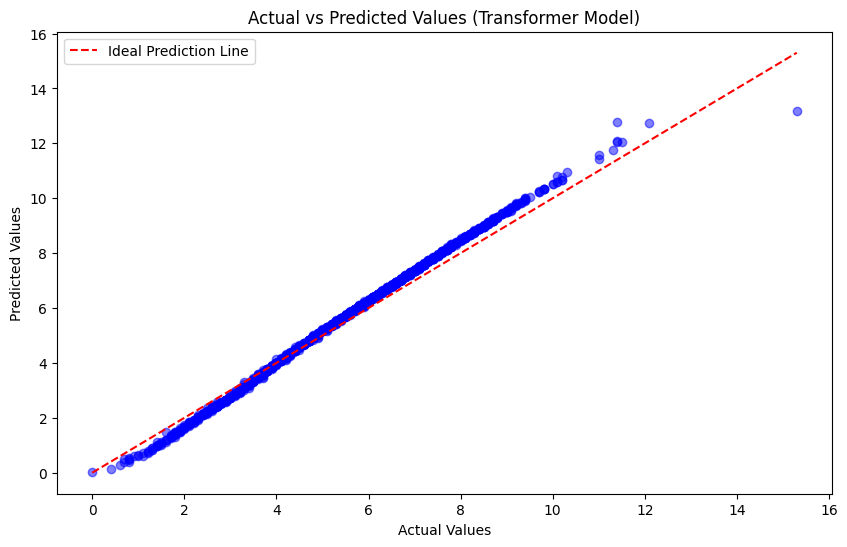

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, y_pred_np, color='blue', alpha=0.5)
plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red', linestyle='--', label='Ideal Prediction Line')
plt.title('Actual vs Predicted Values (Transformer Model)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


In [35]:
# Save the entire model
model_path = r"C:\Users\Haripriya.R\Desktop\studies\SmartWindDashboard\models\transformer_model_complete.pth"
torch.save(model, model_path)
print(f"Entire model saved successfully at {model_path}")


Entire model saved successfully at C:\Users\Haripriya.R\Desktop\studies\SmartWindDashboard\models\transformer_model_complete.pth


In [36]:
# Load the entire model
model = torch.load(model_path)
model.eval()  # Set to evaluation mode
print("Entire model loaded successfully!")


Entire model loaded successfully!


In [37]:
print("Training features used:", X.columns.tolist())


Training features used: ['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'TEMP_ATTRIBUTES', 'DEWP', 'DEWP_ATTRIBUTES', 'SLP', 'SLP_ATTRIBUTES', 'STP', 'STP_ATTRIBUTES', 'VISIB', 'VISIB_ATTRIBUTES', 'WDSP_ATTRIBUTES', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'FRSHTT', 'Humidity', 'Temp_Range', 'Wind_Range', 'Humidity_Index']


In [42]:
import pandas as pd
import numpy as np
import torch

# Provided test data
data = {
    "STATION": [43279099999, 43279099999, 43279099999, 43279099999],
    "LATITUDE": [12.994414, 12.994414, 12.994414, 12.994414],
    "LONGITUDE": [80.180517, 80.180517, 80.180517, 80.180517],
    "ELEVATION": [15.84, 15.84, 15.84, 15.84],
    "TEMP": [78, 77.8, 79.1, 78.6],
    "TEMP_ATTRIBUTES": [11, 11, 11, 9],
    "DEWP": [68.7, 68.7, 69.2, 67.9],
    "DEWP_ATTRIBUTES": [11, 11, 11, 9],
    "SLP": [1013.1, 1015.1, 1015, 1014.9],
    "SLP_ATTRIBUTES": [6, 7, 6, 7],
    "STP": [11.3, 13.3, 13.2, 13.1],
    "STP_ATTRIBUTES": [6, 7, 6, 7],
    "VISIB": [3.9, 3.9, 3.4, 3.8],
    "VISIB_ATTRIBUTES": [9, 10, 9, 8],
    "WDSP": [3.3, 3.3, 5.2, 3.5],
    "WDSP_ATTRIBUTES": [11, 11, 11, 9],
    "MXSPD": [6, 9.9, 12, 9.9],
    "MAX": [88.2, 84.9, 86, 86],
    "MIN": [68, 69.8, 69.8, 70.7],
    "PRCP": [0, 0, 0, 0],
    "FRSHTT": [0, 0, 10000, 0],
    "Humidity": [88.07692308, 88.3033419, 87.48419722, 86.38676845],
    "GUST":[0,0,0,0],
}

# Create DataFrame
test_df = pd.DataFrame(data)

# Compute missing features
test_df["Temp_Range"] = test_df["MAX"] - test_df["MIN"]
test_df["Wind_Range"] = test_df["MXSPD"] - test_df["WDSP"]
test_df["GUST"] = test_df["GUST"].fillna(0)  # Replace NaN GUST values with 0
test_df["Humidity_Index"] = test_df["Humidity"]  # Assume same as Humidity for simplicity

# Selected features from training
required_features = [
    "STATION", "LATITUDE", "LONGITUDE", "ELEVATION", "TEMP", "TEMP_ATTRIBUTES",
    "DEWP", "DEWP_ATTRIBUTES", "SLP", "SLP_ATTRIBUTES", "STP", "STP_ATTRIBUTES",
    "VISIB", "VISIB_ATTRIBUTES",  "WDSP_ATTRIBUTES", "MXSPD", "GUST",
    "MAX", "MIN", "PRCP", "FRSHTT", "Humidity", "Temp_Range", "Wind_Range", "Humidity_Index"
]

# Ensure all required features are present
test_df = test_df[required_features]

# Scale the test data using the same scaler used in training
X_test_scaled = scaler.transform(test_df)

# Convert to PyTorch tensor
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Reshape to match model's input: (batch_size, seq_len=1, input_dim=26)
X_test_tensor = X_test_tensor.unsqueeze(1)  # Add sequence dimension

# Pass to model and get predictions
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

# Output predictions
print("Predictions:", y_pred)


Predictions: tensor([[13.0380],
        [13.0378],
        [13.0430],
        [13.0379]])
